In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
from dichotomous_multiplication_model_functions import *

In [3]:
index_cols=['location_id','sex_id','age_group_id']

age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [4]:
nutrients = ['vitamin a','folic acid','zinc','iron']
vehicles = ['oil','wheat flour']
location_ids = [163,214,179]

In [5]:
data = pd.read_csv(
        '/ihme/homes/alibow/notebooks/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/LSFF_extraction_clean_data_rich_locations_01_11_2021.csv')
max_covs = (data.loc[data.location_id.isin(location_ids)]
        .loc[data.vehicle.isin(vehicles)]
        .loc[data.value_description!='percent of population eating fortified vehicle'])

max_covs

,location_id,location_name,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
2,163,India,oil,percent of population eating industrially prod...,na,89.400000,87.000000,91.800000
3,163,India,oil,percent of population eating vehicle,na,100.000000,100.000000,100.000000
10,163,India,wheat flour,percent of population eating industrially prod...,na,7.100000,5.600000,9.100000
11,163,India,wheat flour,percent of population eating vehicle,na,83.200000,79.500000,86.500000
22,214,Nigeria,oil,percent of population eating industrially prod...,na,31.398007,28.334431,34.461583
23,214,Nigeria,oil,percent of population eating vehicle,na,98.468212,97.668212,99.234106
30,214,Nigeria,wheat flour,percent of population eating industrially prod...,na,59.925796,57.559902,62.291690
31,214,Nigeria,wheat flour,percent of population eating vehicle,na,60.128114,57.728114,62.494008


In [6]:
l = get_ids('location')
l = l[l['location_id'].isin(location_ids)].filter(['location_id','location_name'])
l

,location_id,location_name
137,163,India
150,179,Ethiopia
183,214,Nigeria


In [7]:
master_coverage = pd.DataFrame()
for nutrient in nutrients:
    if nutrient == 'vitamin a':
        vehicle = 'oil'
    else:
        vehicle = 'wheat flour'
    baseline_coverage, counterfactual_coverage = generate_overall_coverage_rates(nutrient, 
                                                                         vehicle,
                                                                         coverage_levels,
                                                                         years,
                                                                         location_ids)
    baseline_coverage['vehicle'] = vehicle
    baseline_coverage['nutrient'] = nutrient
    baseline_coverage['scenario'] = 'baseline'
    baseline_coverage['coverage_level'] = 'na'
    counterfactual_coverage['vehicle'] = vehicle
    counterfactual_coverage['nutrient'] = nutrient
    counterfactual_coverage['scenario'] = 'counterfactual'
    master_coverage = pd.concat([master_coverage, baseline_coverage.reset_index(), counterfactual_coverage.reset_index()], ignore_index=True)
master_coverage = (master_coverage
                   .set_index([c for c in master_coverage.columns if 'draw' not in c])
                   .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
                   .filter(['mean','2.5%','97.5%'])
                   .reset_index())
master_coverage.head()

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v104/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,coverage_level,location_id,nutrient,scenario,vehicle,year,mean,2.5%,97.5%
0,na,163,vitamin a,baseline,oil,2021,0.243409,0.208067,0.276632
1,na,163,vitamin a,baseline,oil,2022,0.243409,0.208067,0.276632
2,na,163,vitamin a,baseline,oil,2023,0.243409,0.208067,0.276632
3,na,163,vitamin a,baseline,oil,2024,0.243409,0.208067,0.276632
4,na,163,vitamin a,baseline,oil,2025,0.243409,0.208067,0.276632


In [9]:
def make_coverage_bar_charts(nutrient, vehicle):
    plt.figure()
    data = master_coverage.loc[master_coverage.vehicle==vehicle].loc[master_coverage.nutrient.isin(['na',nutrient])].loc[master_coverage.year==2025]
    data['mean'] = data['mean'] * 100
    data['2.5%'] = data['2.5%'] * 100
    data['97.5%'] = data['97.5%'] * 100
    base = data.loc[data.scenario=='baseline']
    alt_20 = data.loc[data.coverage_level==0.2]
    alt_50 = data.loc[data.coverage_level==0.5]
    alt_80 = data.loc[data.coverage_level==0.8]
    barWidth = 0.20
    a = np.arange(len(base))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]
    d = [x + barWidth for x in c]
    plt.bar(a, base['mean'], width=barWidth, yerr = [base['mean'] - base['2.5%'],base['97.5%'] - base['mean']], 
            label='Baseline Coverage')
    plt.bar(b, alt_20['mean'], width=barWidth, yerr = [alt_20['mean'] - alt_20['2.5%'],alt_20['97.5%'] - alt_20['mean']], 
            color='tab:red', label='20% Coverage')
    plt.bar(c, alt_50['mean'], width=barWidth, yerr = [alt_50['mean'] - alt_50['2.5%'],alt_50['97.5%'] - alt_50['mean']], 
            color='tab:orange', label='50% Coverage')
    plt.bar(d, alt_80['mean'], width=barWidth, yerr = [alt_80['mean'] - alt_80['2.5%'],alt_80['97.5%'] - alt_80['mean']], 
            color='tab:green', label='80% Coverage')

    df = (max_covs
          .loc[max_covs.vehicle==vehicle]
          .loc[max_covs.value_description=='percent of population eating vehicle'])
    for i in list(range(0,len(df.location_id.unique()))):
        if i == 0:
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['value_mean'], -0.1 + i, 0.8 + i, 
                   color='black', label='Eating vehicle')
        else: 
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['value_mean'], -0.1 + i, 0.8 + i, 
                   color='black')
        plt.fill_between([-0.1 + i, 0.8 + i], [df.loc[df.location_id==df.location_id.unique()[i]]['value_025_percentile'].values[0]] * 2,
                        [df.loc[df.location_id==df.location_id.unique()[i]]['value_975_percentile'].values[0]] * 2,
                        alpha=0.2, color='black')
    df = (max_covs
          .loc[max_covs.vehicle==vehicle]
          .loc[max_covs.value_description=='percent of population eating industrially produced vehicle'])
    for i in list(range(0,len(df.location_id.unique()))):
        if i == 0:
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['value_mean'], -0.1 + i, 0.8 + i, 
                   linestyle='dashed', color='black', label='Eating industrially produced vehicle')
        else: 
            plt.hlines(df.loc[df.location_id==df.location_id.unique()[i]]['value_mean'], -0.1 + i, 0.8 + i, 
                   linestyle='dashed', color='black')
        plt.fill_between([-0.1 + i, 0.8 + i], [df.loc[df.location_id==df.location_id.unique()[i]]['value_025_percentile'].values[0]] * 2,
                        [df.loc[df.location_id==df.location_id.unique()[i]]['value_975_percentile'].values[0]] * 2,
                        alpha=0.2, color='black')

    plt.legend(bbox_to_anchor=[1.75,1])
    plt.title(f'{nutrient.capitalize()} in {vehicle} fortification coverage')
    plt.ylabel('Percent of population')
    plt.xticks([r + barWidth * 1.5 for r in range(len(df))], np.unique(df['location_name']))

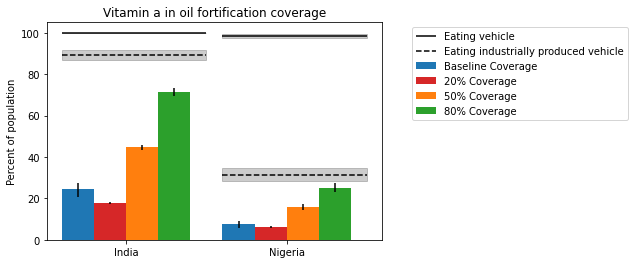

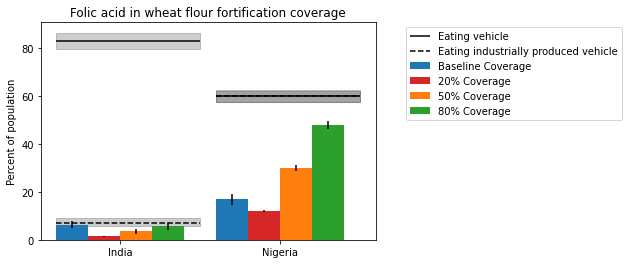

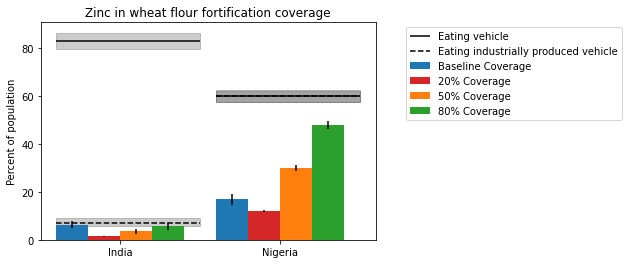

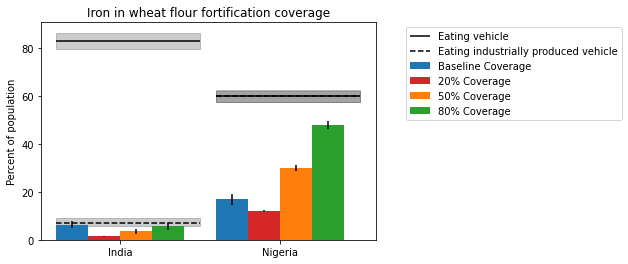

In [10]:
for nutrient in nutrients:
    if nutrient == 'vitamin a':
        vehicle = 'oil'
    else:
        vehicle = 'wheat flour'
    make_coverage_bar_charts(nutrient, vehicle)

In [ ]:
# bar width
    barWidth = 0.25
    
    data = data.loc[data.measure == measure]
        
    data = data.groupby(['location','scenario']).describe(percentiles=[0.1,0.9]).reset_index().sort_values(by='location')
    data1 = data.loc[data.scenario == 'vitamin_a_fortification_scale_up']
    data2 = data.loc[data.scenario == 'folic_acid_fortification_scale_up']
    data3 = data.loc[data.scenario == 'iron_folic_acid_fortification_scale_up']

    data1_mean = data1['value','mean']
    data2_mean = data2['value','mean']
    data3_mean = data3['value','mean']
    
    data1_min = data1['value','mean'] - data1['value','10%']
    data2_min = data2['value','mean'] - data2['value','10%']
    data3_min = data3['value','mean'] - data3['value','10%']
    
    data1_max = data1['value','90%'] - data1['value','mean']
    data2_max = data2['value','90%'] - data2['value','mean']
    data3_max = data3['value','90%'] - data3['value','mean']

    a = np.arange(len(data1))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]

    plt.bar(a, data1_mean, width=barWidth, yerr = [data1_min,data1_max])
    plt.bar(b, data2_mean, width=barWidth, yerr = [data2_min,data2_max])
    plt.bar(c, data3_mean, width=barWidth, yerr = [data3_min,data3_max])

In [20]:
def make_fortification_coverage_plots(nutrient, vehicle, location):
    plt.figure(figsize=(5, 3), dpi=150)
    location_name = l.loc[l.location_id==location]['location_name'].values[0]
    colors=['tab:green','tab:orange','tab:red']

    data = (master_coverage
            .loc[master_coverage.location_id==location]
            .loc[master_coverage.nutrient==nutrient]
            .loc[master_coverage.vehicle==vehicle])
    baseline = data.loc[data.scenario == 'baseline']
    
    p = (max_covs.loc[max_covs.location_id==location]
         .loc[max_covs.vehicle==vehicle]
         .loc[max_covs.value_description=='percent of population eating industrially produced vehicle'])
    plt.hlines(p['value_mean'], 2021-0.07, 2025.07, linestyles='dashed', color='grey', 
               label=f'Percent of population eating industrially produced vehicle')
    plt.fill_between([2021-0.07,2025.07], 
                     [p['value_025_percentile'].values[0]] * 2, 
                     [p['value_975_percentile'].values[0]] * 2, 
                     alpha=0.2,
                     color='grey')
    
    plt.hlines(baseline['mean'] * 100, 2021-0.07, 2025.07, color='tab:blue', 
               label=f'Baseline percent of population eating fortified vehicle')
    plt.fill_between([2021- 0.07,2025.07], 
                     [baseline['2.5%'].values[0] * 100] * 2, 
                     [baseline['97.5%'].values[0] * 100] * 2, 
                     alpha=0.2,
                     color='tab:blue')
    
    alt = data.loc[data.scenario == 'counterfactual']
    for i in list(range(0,len([0.8,0.5,0.2]))):
        p = (alt.loc[alt.coverage_level == [0.8,0.5,0.2][i]])
        if i == 0:
            p['year'] = p['year'] - 0.07
        elif i == 2:
            p['year'] = p['year'] + 0.07
        plt.scatter(p.year, p['mean'] * 100, c=colors[i], s=20, 
                    label=f'{int([0.8,0.5,0.2][i] * 100)} percent counterfactual fortification coverage')
        for n in list(range(0,len(p.year))):
            plt.plot([p[n:n+1].year.values] * 2, 
                     [p[n:n+1]['2.5%'].values[0] * 100, p[n:n+1]['97.5%'].values[0] * 100],
                     color=colors[i])
            
    
    plt.hlines(baseline['mean'] * 100, 2021-0.07, 2025.07, color='tab:blue')
    plt.fill_between([2021- 0.07,2025.07], 
                     [baseline['2.5%'].values[0] * 100] * 2, 
                     [baseline['97.5%'].values[0] * 100] * 2, 
                     alpha=0.2,
                     color='tab:blue')
    plt.xticks(years)
    plt.xlabel('Year')
    plt.ylabel('Percent of population\nconsuming fortified vehicle')
    plt.title(f'Population coverage of {nutrient} fortified {vehicle} in {location_name}')
    plt.legend(bbox_to_anchor=(1.05, 1))

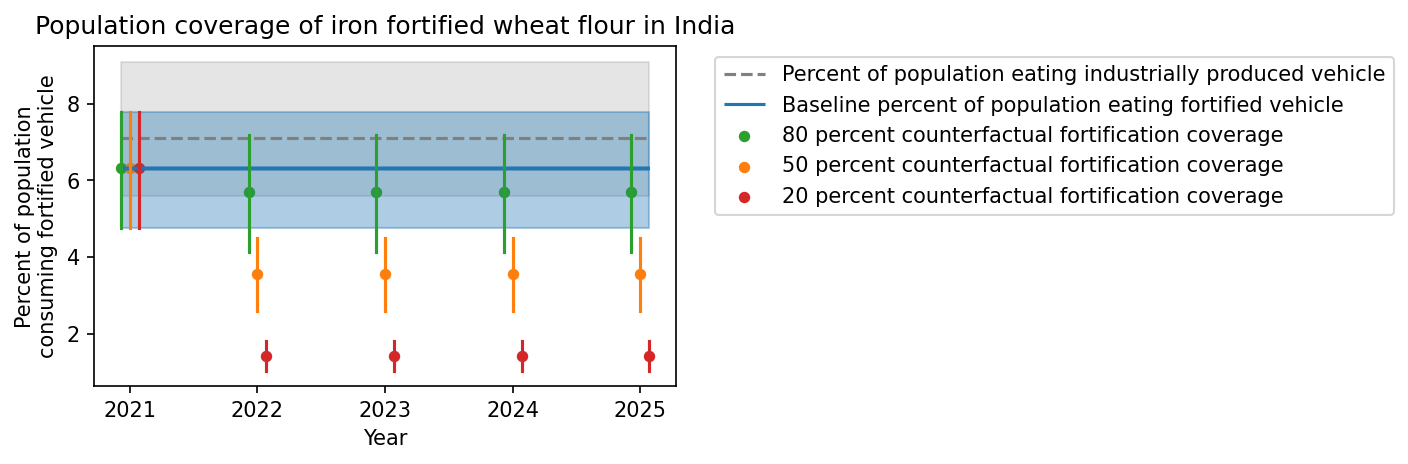

In [21]:
make_fortification_coverage_plots(nutrient, vehicle, 163)

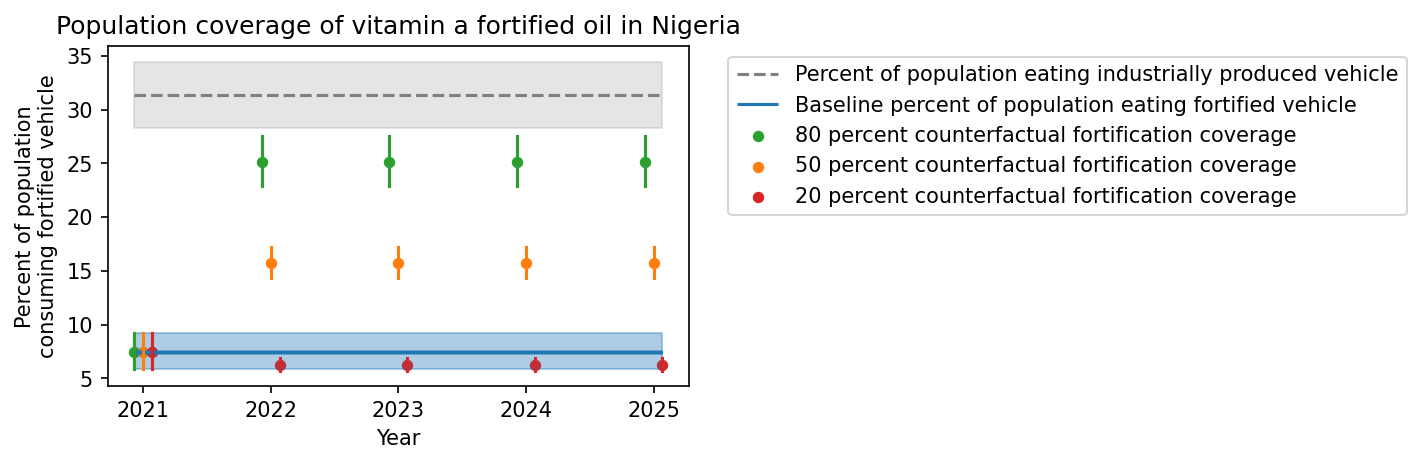

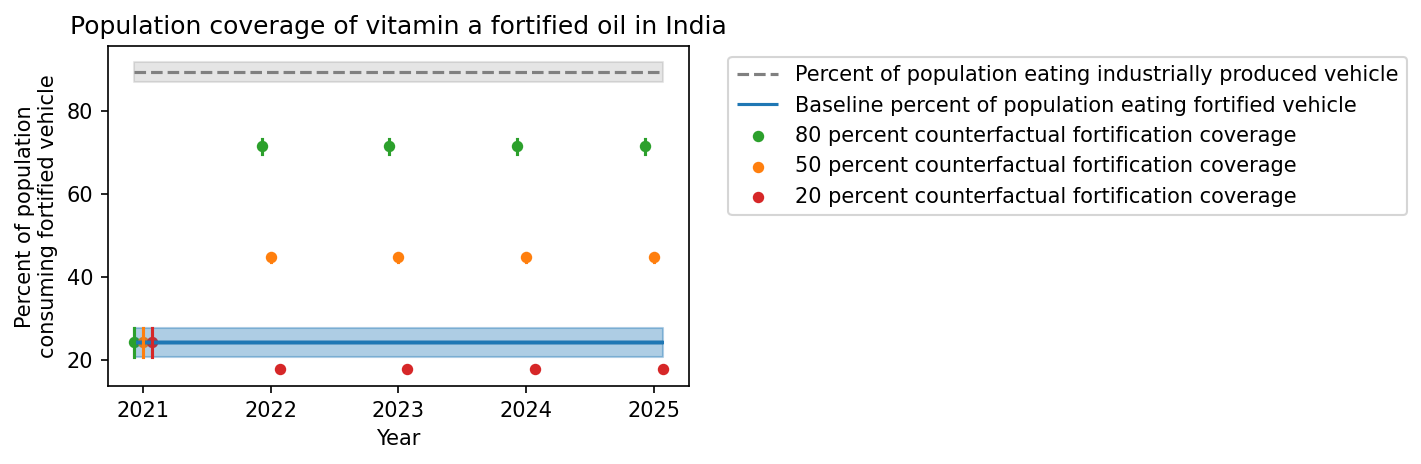

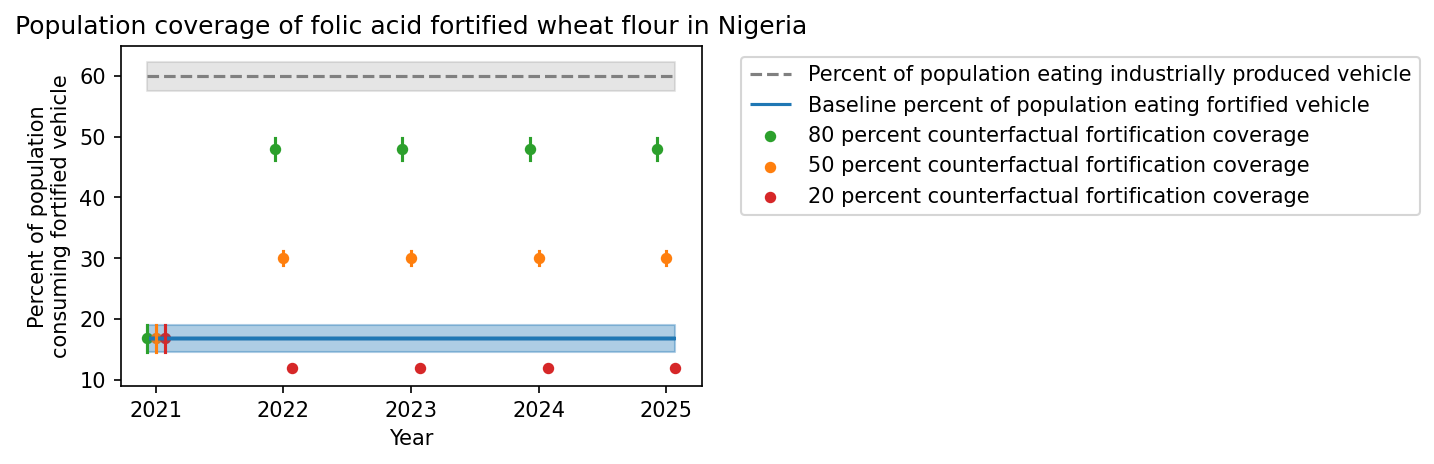

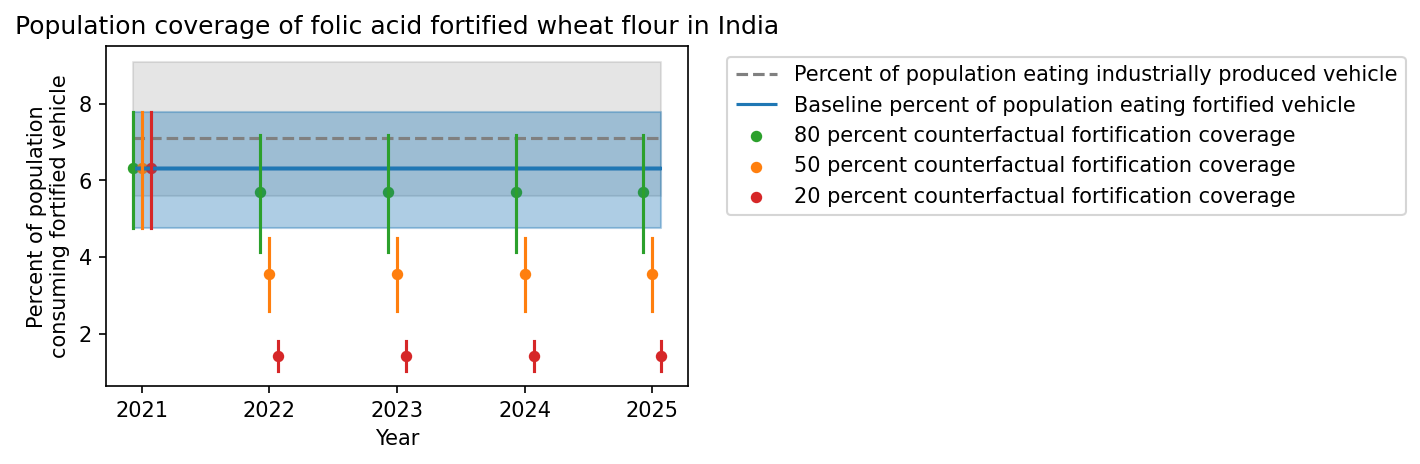

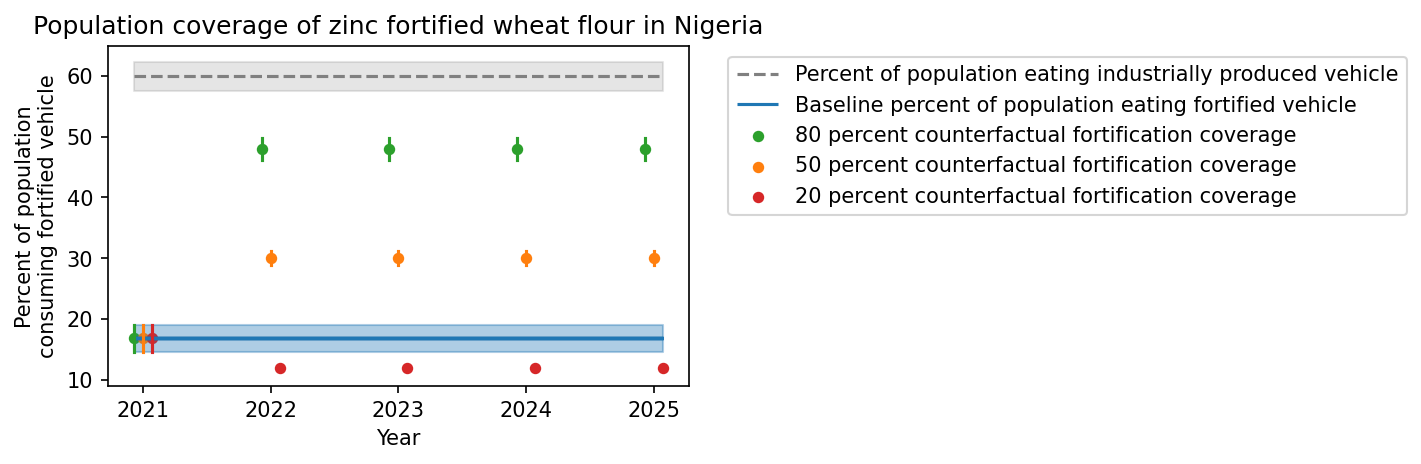

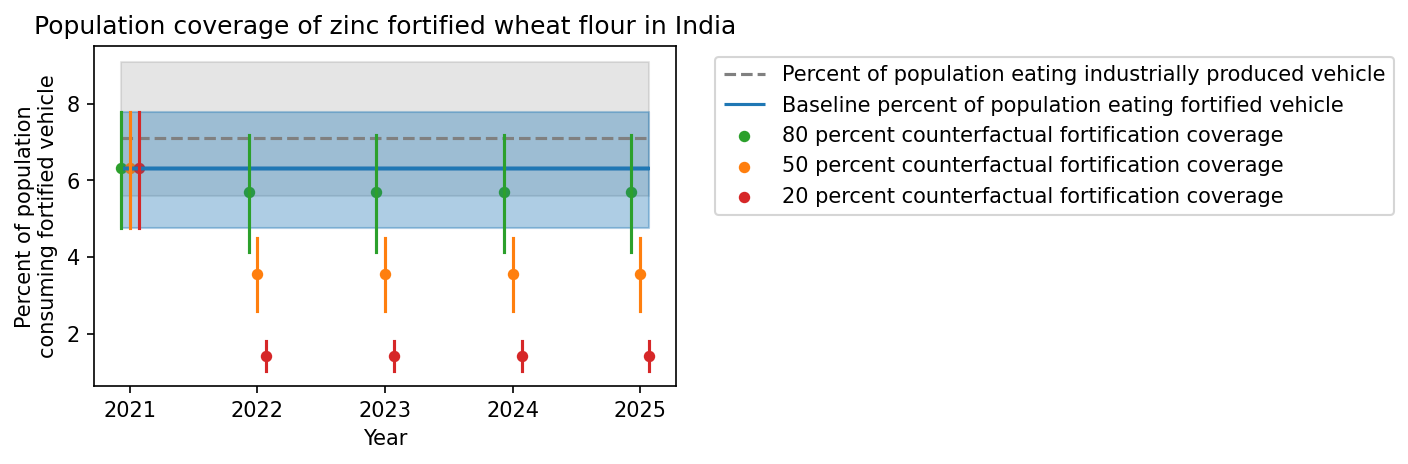

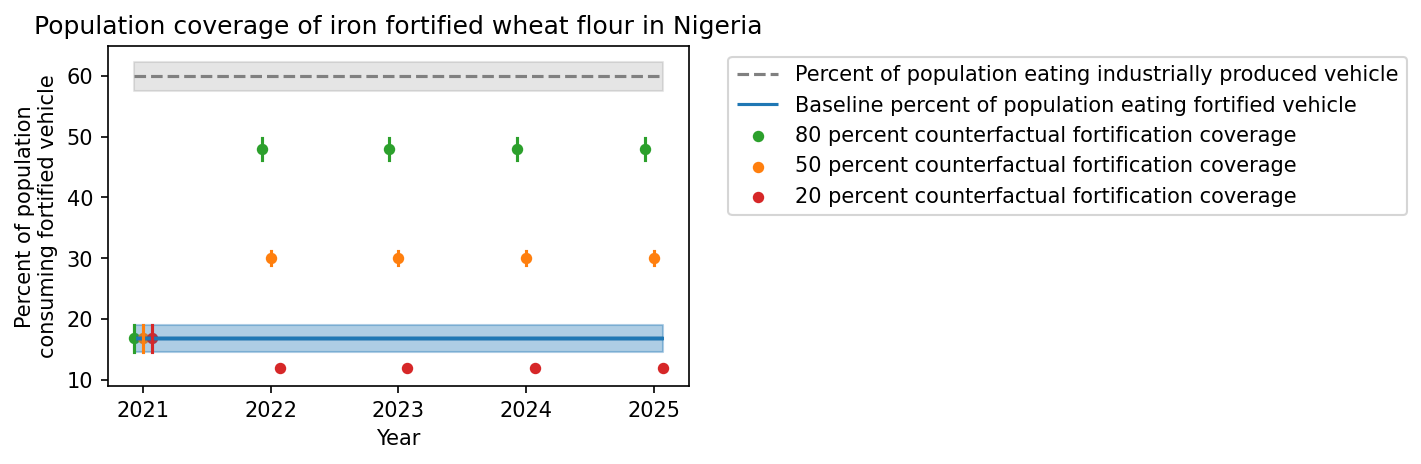

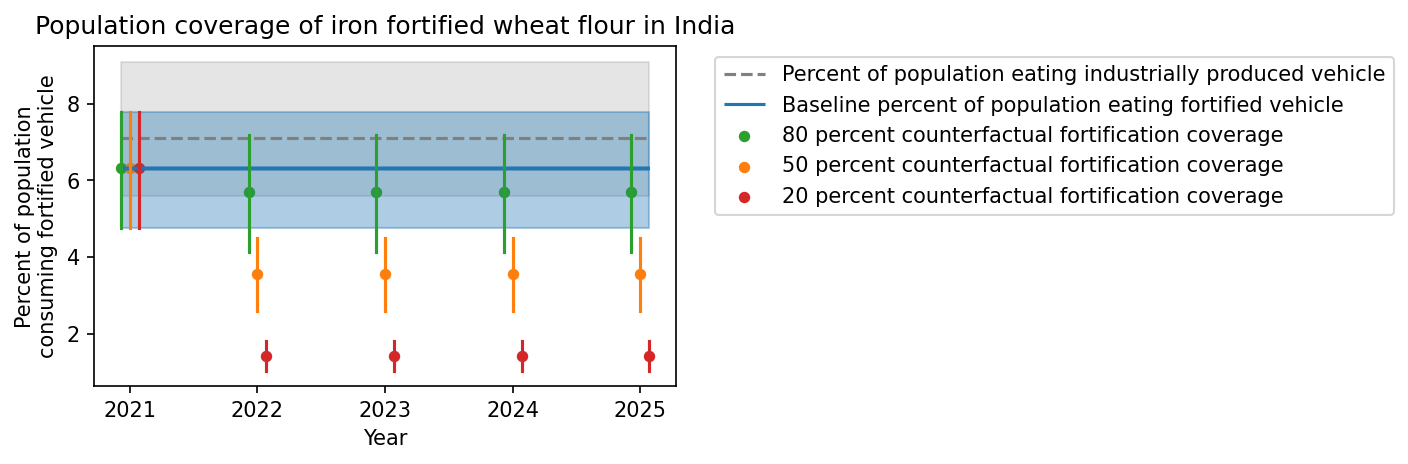

In [22]:
for nutrient in nutrients:
    if nutrient == 'vitamin a':
        vehicle = 'oil'
    else:
        vehicle = 'wheat flour'
    for location in [214,163]:
        make_fortification_coverage_plots(nutrient, vehicle, location)